Import Library

In [1]:
import os
import torch
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim


Load Datasets

In [2]:
# Load EMNIST dataset
train_data = pd.read_csv('C:/Kuliah/Semester 5/Machine Vision/Ujian/archive (7)/emnist-bymerge-train.csv', header=None, nrows=2000)
test_data = pd.read_csv('C:/Kuliah/Semester 5/Machine Vision/Ujian/archive (7)/emnist-bymerge-test.csv', header=None, nrows=2000)


Reshape dan Normalize Image Menjadi Range 0 - 1 

In [3]:
#reshape data agar sesuai dengan format CNN
x_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32')
y_train = train_data.iloc[:, 0].values.astype('int')
x_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32')
y_test = test_data.iloc[:, 0].values.astype('int')


#gambar rgb memiliki range 0 - 255
#sedangkan beberapa arsitektur standar yang ada di cnn menggunakan range 0 - 1
#jadi mesti dirubah terlebih dahulu dengan cara menormalize image dengan nilai mean dan standar deviasi dari masing" intensity rgb dari datasets 
x_train = x_train.reshape(-1, 1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 1, 28, 28) / 255.0

Merubah Format Gambar Menjadi Square

In [4]:
# Resize ke 224x224
# untuk menggunakan cnn, size image yang ada pada direktori harus sama ukurannya, jika berbeda tidak akan bisa
import torch.nn.functional as F

x_train_resized = F.interpolate(torch.tensor(x_train), size=(224, 224), mode='bilinear')
x_test_resized = F.interpolate(torch.tensor(x_test), size=(224, 224), mode='bilinear')

Duplicate Channel ke RGB

In [5]:
# Duplicate channel untuk grayscale -> RGB (1 channel -> 3 channel)
x_train_rgb = x_train_resized.repeat(1, 3, 1, 1)  # (batch_size, 3, 224, 224)
x_test_rgb = x_test_resized.repeat(1, 3, 1, 1)

Normalisasi Datasets

In [6]:
#Melakukan normalisasi datasets
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

x_train_normalized = (x_train_rgb - mean) / std
x_test_normalized = (x_test_rgb - mean) / std

Merubah Label menjadi Bentuk Tensor

In [7]:
# Konversi label menjadi tensor
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

Membuat Tensor Dataset

In [8]:
# Buat TensorDataset
train_dataset = TensorDataset(x_train_normalized, y_train_tensor)
test_dataset = TensorDataset(x_test_normalized, y_test_tensor)

Membuat Data Loader

In [9]:
#datasets yang kita punya tadi masukkan ke dalam data loader
#tujuan dataloader ialah tidak melakukan proses training perimage, tetapi beberapa image sekaligus
# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Menggunakan Metode Transfer Learning dan Arsitektur Alexnet

In [10]:
from torchvision import models

model = models.alexnet(pretrained=True) #mendownload model arsitektur beserta parameternya yaitu weight dan bias
model

c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# Ganti layer output untuk jumlah kelas Anda (misalnya 47 kelas untuk EMNIST)
import torch.nn as nn

model.classifier[6] = torch.nn.Linear(4096, 47)

In [12]:
#untuk melakukan proses training, kita perlu mendefinisikan loss function
#karena ini adalah masalah klasifikasi multi-kelas, fungsi kerugian yang umum digunakan adalah kerugian entropi silang kategorikal

criterion = nn.CrossEntropyLoss()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
device = torch.device('cpu')

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Training CNN

In [15]:
num_epoch = 10
list_loss = []
list_acc = []

for epoch in range(num_epoch):
    train_loss = 0.0
    train_corrects = 0

    model.train()  # Set model ke mode pelatihan
    for inputs, labels in train_loader:  # Gunakan train_loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradien

        outputs = model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Prediksi label
        loss = criterion(outputs, labels)  # Hitung loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameter

        train_loss += loss.item() * inputs.size(0)  # Total loss
        train_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi benar

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_corrects.double() / len(train_loader.dataset)

    list_loss.append(epoch_loss)
    list_acc.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epoch} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')


Epoch 1/10 - Loss: 2.5773, Acc: 0.3625
Epoch 2/10 - Loss: 0.9548, Acc: 0.7045
Epoch 3/10 - Loss: 0.5701, Acc: 0.8105
Epoch 4/10 - Loss: 0.4124, Acc: 0.8590
Epoch 5/10 - Loss: 0.3563, Acc: 0.8730
Epoch 6/10 - Loss: 0.2910, Acc: 0.8970
Epoch 7/10 - Loss: 0.2469, Acc: 0.9065
Epoch 8/10 - Loss: 0.2065, Acc: 0.9250
Epoch 9/10 - Loss: 0.1880, Acc: 0.9220
Epoch 10/10 - Loss: 0.1774, Acc: 0.9355


Evaluasi CNN

In [16]:
    model.eval()  # Set model ke mode evaluasi
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():  # Non-aktifkan gradien
        for inputs, labels in test_loader:  # Gunakan test_loader
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f'Test - Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}')


Test - Loss: 0.6056, Acc: 0.8125


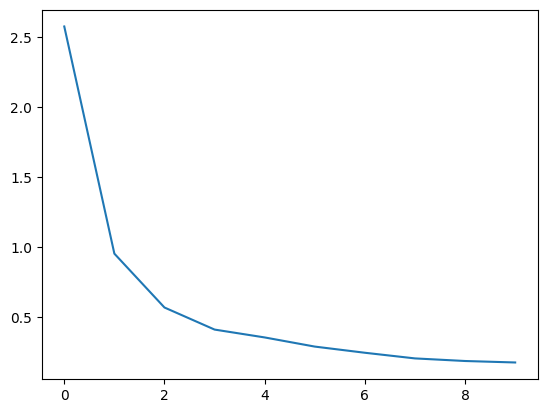

In [17]:
plt.plot(list_loss)

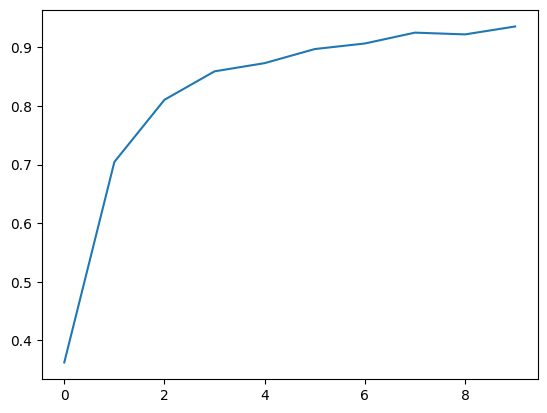

In [18]:
plt.plot(list_acc)

 Fungsi untuk melatih model neural network untuk mengevaluasi performa pada data validasi atau test.

In [19]:
from sklearn.model_selection import KFold
import torch.nn.functional as F

# Model Training Function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

LOOCV

In [20]:
loo = LeaveOneOut()
all_preds = []
all_labels = []

In [21]:
# Container for metrics
loocv_accuracies = []

In [22]:
# LOOCV
for i in range(min(10, len(x_train_normalized))):
    print(f"LOOCV Iteration {i + 1}/{min(10, len(x_train_normalized))}")
    
    # Split data
    X_test_loocv = x_train_normalized[i:i + 1]
    y_test_loocv = y_train_tensor[i:i + 1]
    X_train_loocv = torch.cat((x_train_normalized[:i], x_train_normalized[i + 1:]), dim=0)
    y_train_loocv = torch.cat((y_train_tensor[:i], y_train_tensor[i + 1:]), dim=0)
    
    # Prepare DataLoader
    train_dataset_loocv = TensorDataset(X_train_loocv, y_train_loocv)
    train_loader_loocv = DataLoader(train_dataset_loocv, batch_size=64, shuffle=True)
    
    # Reinitialize model for each LOOCV iteration
    model_loocv = models.alexnet(pretrained=True)
    model_loocv.classifier[6] = nn.Linear(4096, 47)
    model_loocv.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_loocv.parameters(), lr=0.0001)
    
    # Train model
    trained_model = train_model(model_loocv, train_loader_loocv, criterion, optimizer, device, num_epochs=5)
    
    # Evaluate model
    trained_model.eval()
    with torch.no_grad():
        inputs, labels = X_test_loocv.to(device), y_test_loocv.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        acc = (preds == labels).sum().item() / labels.size(0)
        loocv_accuracies.append(acc)

        # Append predictions and true labels
        all_preds.append(preds.cpu().item())
        all_labels.append(labels.cpu().item())


LOOCV Iteration 1/10
LOOCV Iteration 2/10
LOOCV Iteration 3/10
LOOCV Iteration 4/10
LOOCV Iteration 5/10
LOOCV Iteration 6/10
LOOCV Iteration 7/10
LOOCV Iteration 8/10
LOOCV Iteration 9/10
LOOCV Iteration 10/10


In [23]:
# Report Results
print(f"LOOCV Mean Accuracy: {np.mean(loocv_accuracies):.4f}")

LOOCV Mean Accuracy: 0.7000


In [24]:

# Hitung metrik evaluasi
loo_confusion_matrix = confusion_matrix(all_labels, all_preds)
loo_accuracy = accuracy_score(all_labels, all_preds)
loo_precision = precision_score(all_labels, all_preds, average='weighted')
loo_recall = recall_score(all_labels, all_preds, average='weighted')
loo_f1 = f1_score(all_labels, all_preds, average='weighted')

c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
print("\nLOOCV Result Data Training:")
print("Confusion Matrix:")
print(loo_confusion_matrix)
print(f"Accuracy: {loo_accuracy:.4f}")
print(f"Precision: {loo_precision:.4f}")
print(f"Recall: {loo_recall:.4f}")
print(f"F1 Score: {loo_f1:.4f}")


LOOCV Result Data Training:
Confusion Matrix:
[[0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
Accuracy: 0.7000
Precision: 0.6333
Recall: 0.7000
F1 Score: 0.6600


In [26]:
import seaborn as sns
def plot_confusion_mat(cm):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


<Axes: >

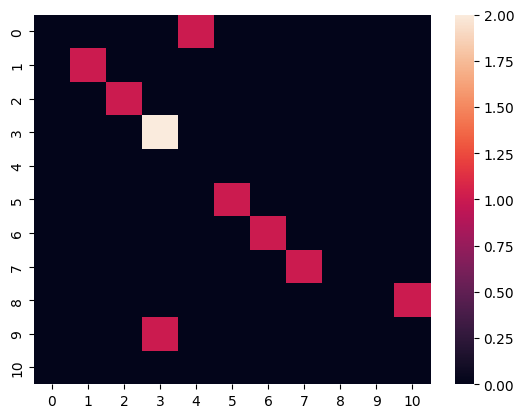

In [27]:
sns.heatmap(loo_confusion_matrix)

c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

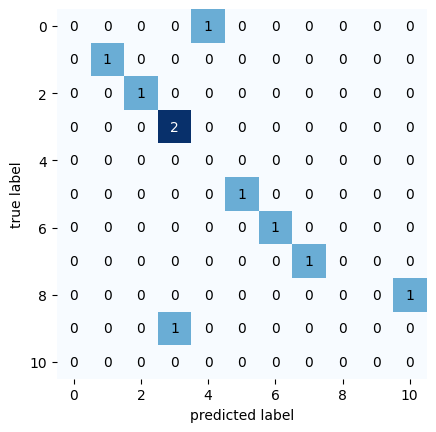

In [28]:
# Misalkan Anda memiliki 47 kelas:
class_names = [f"Class {i}" for i in range(47)]  # Ganti dengan nama kelas sebenarnya jika ada
plot_confusion_matrix(loo_confusion_matrix, class_names)


K-Fold

In [29]:
# K-Fold Cross-Validation adalah metode evaluasi model pembelajaran mesin yang membagi dataset menjadi k bagian atau lipatan (folds). 
# Tujuannya adalah untuk mengurangi bias evaluasi dan memanfaatkan seluruh dataset secara efisien.
# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


In [30]:
# Container for metrics
kfold_accuracies = []


In [31]:
# K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_normalized)):
    print(f"Fold {fold+1}/{k_folds}")
    
    # Split data
    X_train_kf = x_train_normalized[train_idx]
    y_train_kf = y_train_tensor[train_idx]
    X_val_kf = x_train_normalized[val_idx]
    y_val_kf = y_train_tensor[val_idx]
    
    # Prepare DataLoader
    train_dataset_kf = TensorDataset(X_train_kf, y_train_kf)
    val_dataset_kf = TensorDataset(X_val_kf, y_val_kf)
    train_loader_kf = DataLoader(train_dataset_kf, batch_size=64, shuffle=True)
    val_loader_kf = DataLoader(val_dataset_kf, batch_size=64, shuffle=False)
    
    # Reinitialize model for each fold
    model_kf = models.alexnet(pretrained=True)
    model_kf.classifier[6] = nn.Linear(4096, 47)
    model_kf.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_kf.parameters(), lr=0.0001)
    
    # Train model
    trained_model = train_model(model_kf, train_loader_kf, criterion, optimizer, device, num_epochs=5)
    
    # Evaluate model
    trained_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_kf:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    fold_acc = correct / total
    kfold_accuracies.append(fold_acc)
    print(f"Accuracy for Fold {fold+1}: {fold_acc:.4f}")


Fold 1/5


c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy for Fold 1: 0.7700
Fold 2/5
Accuracy for Fold 2: 0.7675
Fold 3/5
Accuracy for Fold 3: 0.7650
Fold 4/5
Accuracy for Fold 4: 0.7925
Fold 5/5
Accuracy for Fold 5: 0.7800


In [32]:
print(f"K-Fold Mean Accuracy: {np.mean(kfold_accuracies):.4f}")

K-Fold Mean Accuracy: 0.7750
